In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential


# Load data 

In [2]:
correct_queries = pd.read_csv('dataset/correct_queries.csv')
correct_incorrect_queries = pd.read_csv('dataset/correct_incorrect_queries.csv')

# EDA

In [3]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

correct_queries_text = [preprocess_text(query) for query in correct_queries['query']]
correct_incorrect_queries_text = [
    [preprocess_text(misspelled_query), preprocess_text(query)]
    for misspelled_query, query in zip(correct_incorrect_queries['misspelled_query'], correct_incorrect_queries['query'])
]

In [4]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(correct_queries_text + [text[0] for text in correct_incorrect_queries_text])


In [5]:
# Convert text to numeric tokens
correct_queries_sequences = tokenizer.texts_to_sequences(correct_queries_text)
correct_incorrect_queries_sequences = [
    [tokenizer.texts_to_sequences([text[0]])[0], tokenizer.texts_to_sequences([text[1]])[0]]
    for text in correct_incorrect_queries_text
]

In [6]:
# Data preparation
max_length = max([len(seq) for seq in correct_queries_sequences + [seq[0] for seq in correct_incorrect_queries_sequences]])

correct_queries_padded = pad_sequences(correct_queries_sequences, maxlen=max_length)
correct_incorrect_queries_padded = [
    [pad_sequences([seq[0]], maxlen=max_length)[0], pad_sequences([seq[1]], maxlen=max_length)[0]]
    for seq in correct_incorrect_queries_sequences
]

correct_labels = np.array([1] * len(correct_queries_padded))
incorrect_labels = np.array([0] * len(correct_incorrect_queries_padded))

all_queries = np.concatenate((correct_queries_padded, [seq[0] for seq in correct_incorrect_queries_padded]), axis=0)

all_labels = np.concatenate((correct_labels, incorrect_labels), axis=0)

x_train, x_val, y_train, y_val = train_test_split(all_queries, all_labels, test_size=0.2, random_state=42)


# Model Development

In [7]:
# Neural network model
model = Sequential([
    Embedding(input_dim=tokenizer.num_words + 1, output_dim=128, input_length=max_length),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\Reza-pc\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# Model training
history=model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9376 - loss: 0.1932 - val_accuracy: 0.9693 - val_loss: 0.0961
Epoch 2/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9849 - loss: 0.0532 - val_accuracy: 0.9712 - val_loss: 0.1055
Epoch 3/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9914 - loss: 0.0329 - val_accuracy: 0.9710 - val_loss: 0.1119
Epoch 4/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9933 - loss: 0.0226 - val_accuracy: 0.9698 - val_loss: 0.1082
Epoch 5/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9954 - loss: 0.0157 - val_accuracy: 0.9689 - val_loss: 0.1305
Epoch 6/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.9967 - loss: 0.0109 - val_accuracy: 0.9689 - val_loss: 0.1397
Epoch 7/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 0.9657 - val_loss: 0.1621
Epoch 8/10
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9981 -

In [9]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_val, y_val)
print(f'Test accuracy: {test_acc * 100:.2f}%')

338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9663 - loss: 0.2151
Test accuracy: 96.64%


In [10]:
import matplotlib.pyplot as plt
def plot_history(history):
    if "accuracy" in history.history.keys():
        fig1, ax1 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        losses = history.history["accuracy"]
        last_loss = losses[-1] 
        ax1.plot(losses, label=f"accuracy: {last_loss:.4f}", color="blue")
        ax1.legend()
        ax1.grid()
        ax1.set_title("accuracy", fontsize=15)
    if "loss" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        val_loss = history.history["loss"]
        val_losses = val_loss[-1] 
        ax2.plot(history.history["loss"], label=f"loss: {val_losses:.4f}", color="green")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    if "val_accuracy" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        mean_absolute_error = history.history["val_accuracy"]
        mean_absolute_error = mean_absolute_error[-1] 
        ax2.plot(history.history["val_accuracy"], label=f"val_accuracy: {mean_absolute_error:.4f}", color="black")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    if "val_loss" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        val_mean_absolute_error = history.history["val_loss"]
        val_mean_absolute_error = val_mean_absolute_error[-1] 
        ax2.plot(history.history["val_loss"], label=f"val_loss: {val_mean_absolute_error:.4f}", color="red")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    return None

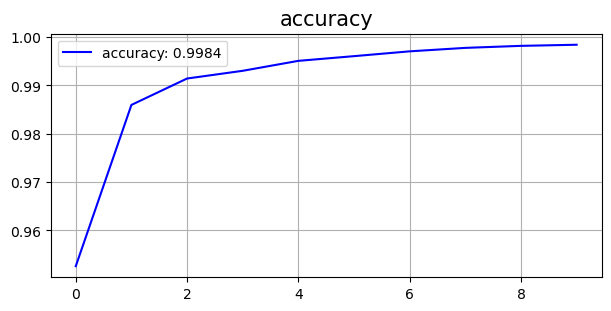

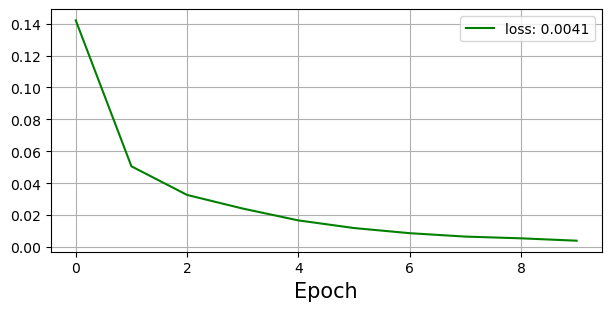

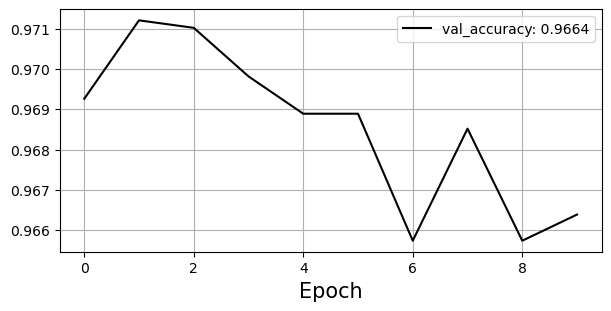

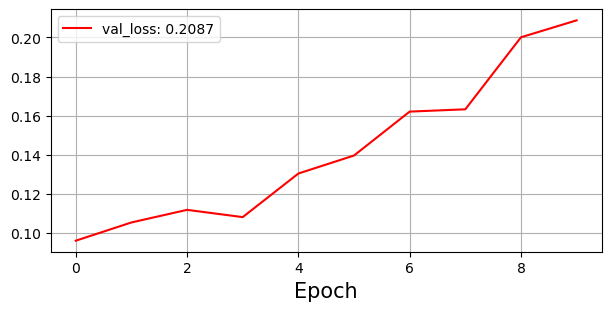

In [11]:
plot_history(history)

In [12]:
# Load test data
test_data = pd.read_csv('dataset/test.csv')
test_queries = [preprocess_text(query) for query in test_data['raw_query']]
test_queries_sequences = tokenizer.texts_to_sequences(test_queries)
test_queries_padded = pad_sequences(test_queries_sequences, maxlen=max_length)


# predict 

In [13]:
# Prediction for test data
predictions = model.predict(test_queries_padded)


339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [14]:
# Post-processing of the results
corrected_queries = []
for i, prediction in enumerate(predictions):
    if prediction > 0.5:
        corrected_query = ' '.join(test_queries[i])
    else:
        corrected_query = test_data['raw_query'][i]

    corrected_queries.append(corrected_query)


# Output

In [15]:
# Save the output in my_output.csv file
output = pd.DataFrame({'raw_query': test_data['raw_query'], 'query': corrected_queries})
output.to_csv('my_output.csv', index=False)